# 0. Introduction

**Purpose of this notebook 🎯**

This notebook aim to achieve 2 things:

1. Explain the data in simple language, especially to those without a financial background. 

2. Provide a simple lightGBM workflow as baseline.

This notebook assumes that you are fimilar with the submission API. I explored the API a little bit in my another notebook:

[Understand the Submission API🕵️](https://www.kaggle.com/code/a27182818/understand-the-submission-api)

Check it out, if you are interested!

-----

**Table of Contents**📚

- **0. Introduction**

- **1. Explore & Explain the Data**

    - 1.1. Understand the structure

        - 1.1.1. A glimpse of the data

        - 1.1.2. What type of data are missing?

    - 1.2. Understand the features

        - 1.2.1 Order book

        - 1.2.2. Auction Order Book

        - 1.2.3. Combined Book

    - 1.3. Understand the target

- **2. LightGBM Baseline**

    - 2.1. Naive Baseline

    - 2.2. Simplest LightGBM Solution

    - 2.3. Improved LightGBM Solution

- **3. Final Thoughts**

In [48]:
# For Kaggle

# Standard Libraries
import sys
import os
import collections

# Data Science Libraries
import pandas as pd
import numpy as np
import optuna

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Statistics Libraries
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.graphics.api as smg

# ML Libraries
import sklearn as sk
import lightgbm
import xgboost
import catboost

# Project Libraries
import optiver2023

# Configure Visualization
%matplotlib inline
plt.style.use('bmh')

# Configure Pandas and SKLearn
pd.set_option("display.max_colwidth", 20)
pd.set_option("display.precision", 3)
sk.set_config(display="diagram")

# File Specific Configurations
DATA_DIR = "/data/"
plt.rcParams['figure.dpi'] = 270
START = pd.Timestamp.now()
SEED = 42

ModuleNotFoundError: No module named 'optiver2023'

Throughout this notebook, I will repeatedly use the "method chaining" code style when deal with dataframes, and it may not commonly be seen in other people's notebooks.

Such code style are resemble to the 'pipe' in the R language. I found they are easy to read and to debug,  once you have got fimilar with them, although it is totally opinionated.

Some of you may find it unfamiliar and therefore hard to understand when first encounter it, so I explain it here.

In [19]:
# First define a df for demonstration
df = pd.DataFrame({"a": [1, 2, 3, 4], "b": [4, 5, 6, 1]})
df

,a,b
0,1,4
1,2,5
2,3,6
3,4,1


In [20]:
# The "Method Chaining" style, which I will use in this notebook

df1 = (df
    .query("a > 1") # subset rows
    .assign(c=lambda x: x["a"] + x["b"]) # add a new column based on existing columns
    .loc[:, ["b", "c"]] # subset columns
    .sort_values("b", ascending=False) # sort by a column
)

df1

,b,c
2,6,9
1,5,7
3,1,5


In [21]:
# The Common style

df2 = df.copy()
df2 = df2[df2["a"] > 1] # subset rows
df2["c"] = df2["a"] + df2["b"] # add a new column based on existing columns
df2 = df2[["b", "c"]] # subset columns
df2 = df2.sort_values("b", ascending=False) # sort by a column
df2

,b,c
2,6,9
1,5,7
3,1,5


# 1. Explore & Explain the Data

**Purpose of this section 🎯**

- 1.1. Explore the structure of the data.

- 1.2. Understand each **feature** intuitively.

- 1.3. Speculate how each **feature** influence the **target**.

**Inspiration and Credits:**

- [Optiver - Trading At The Close Introduction](https://www.kaggle.com/code/tomforbes/optiver-trading-at-the-close-introduction) provides a nice explanation on the differences between **Order book** and **Auction order book**. They are the keys to understand the data. We incorporate some of their graphs and explanations into this notebook.

## 1.1. Understand the structure

### 1.1.1. A glimpse of the data

In [22]:
def inspect_columns(df):
    # A helper function that does a better job than df.info() and df.describe()
    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return result

In [27]:
Xy_train = pd.read_csv("data/train.csv")
Xy_train

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3.181e+06,1,1.000,1.338e+07,NaN,NaN,1.000,60651.50,1.000,8493.03,1.000,-3.030,0,0_0_0
1,1,0,0,1.666e+05,-1,1.000,1.642e+06,NaN,NaN,1.000,3233.04,1.001,20605.09,1.000,-5.520,0,0_0_1
2,2,0,0,3.029e+05,-1,1.000,1.819e+06,NaN,NaN,0.999,37956.00,1.000,18995.00,1.000,-8.390,0,0_0_2
3,3,0,0,1.192e+07,-1,1.000,1.839e+07,NaN,NaN,1.000,2324.90,1.000,479032.40,1.000,-4.010,0,0_0_3
4,4,0,0,4.475e+05,-1,1.000,1.786e+07,NaN,NaN,0.999,16485.54,1.000,434.10,1.000,-7.350,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2.441e+06,-1,1.000,2.828e+07,1.000,1.000,1.000,32257.04,1.000,319862.40,1.000,2.310,26454,480_540_195
5237976,196,480,540,3.495e+05,-1,1.001,9.188e+06,1.000,1.000,1.001,205108.40,1.001,93393.07,1.001,-8.220,26454,480_540_196
5237977,197,480,540,0.000e+00,0,0.996,1.273e+07,0.996,0.996,0.996,16790.66,0.996,180038.32,0.996,1.169,26454,480_540_197
5237978,198,480,540,1.001e+06,1,0.999,9.477e+07,0.999,0.999,0.999,125631.72,0.999,669893.00,0.999,-1.540,26454,480_540_198


In [28]:
inspect_columns(Xy_train)

,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
stock_id,False,200,False,0.00,0,66,199,int64
date_id,False,481,False,0.00,0,369,480,int64
seconds_in_bucket,False,55,False,0.00,0,410,540,int64
imbalance_size,False,2971863,True,0.00,3180602.69,1926939.07,1884285.71,float64
imbalance_buy_sell_flag,False,3,False,0.00,1,1,-1,int64
reference_price,False,28741,True,0.00,1.0,1.002,1.002,float64
matched_size,False,2948862,True,0.00,13380276.64,5539150.36,24073677.32,float64
far_price,False,95739,True,55.26,NaN,1.09,1.001,float64
near_price,False,84625,True,54.55,NaN,1.04,1.001,float64
bid_price,False,28313,True,0.00,1.0,1.002,1.002,float64


The following guesses could be made, based on the glimpse of the data:

- 200 \* 481 \* 55 = 5,291,000, which is roughly equal to the number of total rows. We assume that

    - The training data consist of 200 * 481 = 96,200 time series;

    - Each time series are 55 steps long, and each time series represents the last 10 mins of a given stock on a given trading date.

- 5,291,000 - 5,237,980 = 53,020, so there are some data missing. 

    - It's normal, as explained in the [Dataset Description](https://www.kaggle.com/competitions/optiver-trading-at-the-close/data): _Not all stock IDs exist in every time bucket_.

    - We will further explore what kind of data missing are we facing here.

- 481 * 55 = 26,455, so `time_id` is just a new id for the permutation of `seconds_in_bucket` and `date_id`.

- `row_id` is a string concatenation of `date_id`, `seconds_in_bucket`, and `stock_id`, separated with underscores.

- `target` is the **target** variable we want to predict, for its namesake.

- Other columns are the **features** (or **covariate** in terms of Time Series ML).

In [29]:
# Take a look at any single time series by setting the stock_id and date_id

stock_id = 6
date_id = 4

(Xy_train
    .query(f'stock_id == {stock_id} & date_id == {date_id}')
    .drop(columns=['stock_id', 'date_id', 'time_id', 'row_id'])
    .head(10)
)

,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
42026,0,126061.42,-1,1.000,4.550e+06,NaN,NaN,1.000,1443.36,1.001,29387.97,1.000,-7.84
42218,10,70729.12,-1,0.999,4.605e+06,NaN,NaN,0.998,48012.00,1.000,48095.00,0.999,5.97
42410,20,65917.61,-1,0.999,4.610e+06,NaN,NaN,0.998,480.13,1.000,48095.00,0.998,16.19
42602,30,100079.30,-1,0.998,4.610e+06,NaN,NaN,0.998,48014.00,1.000,15870.03,0.999,2.18
42794,40,0.00,0,0.999,4.710e+06,NaN,NaN,0.999,6727.70,1.000,2887.32,1.000,-4.70
42986,50,0.00,0,0.999,4.710e+06,NaN,NaN,0.999,14417.40,1.000,4811.80,1.000,-2.91
43178,60,0.00,0,0.999,4.710e+06,NaN,NaN,0.999,4805.80,1.000,5292.98,0.999,-14.79
43370,70,0.00,0,0.999,4.713e+06,NaN,NaN,0.999,4805.80,1.000,5292.98,0.999,-12.59
43562,80,0.00,0,0.999,4.713e+06,NaN,NaN,0.999,4805.80,1.000,5292.98,0.999,-5.46
43754,90,0.00,0,0.999,4.713e+06,NaN,NaN,0.999,4805.80,1.000,7698.88,0.999,-10.62


### 1.1.2. What type of data missing?

There are 3 types of data missing in the world of Time Series:

1. Are there some time series are missing entirely (e.g., some stocks have no data at all on some days)? 

2. Are some time series are missing their steps (e.g., some time series have steps less than 55)?

3. Both?

**The answer to these questions are crucial to our later model building.**

In [30]:
# Let's first exam if all the time series are 55 steps long

(Xy_train
    .groupby(['stock_id', 'date_id'])
    ['seconds_in_bucket'] # Extract the column of interest
    .count() # Count the number of rows in each permutation of stock_id and date_id
    .apply(lambda x: x == 55) # Check if every count is 55
    .all() # Check if all the booleans are True
)

True

The above result suggests that all the time series in our training data are of the same length of 55.

Therefore, it can be concluded that **there are some stocks missing data on some days entirely**.

phew! That's a relief.

From my past experiences, many time series each with a few irregular lose steps are way harder to deal with than a few time series missing entirely while other time series are whole.

Fortunately, that kind of problem is not the case here. 

Next, let's keep exploring which stocks are missing data on which days?

In [31]:
all_stock_id = np.sort(Xy_train["stock_id"].unique())
print(all_stock_id[:10])
print(all_stock_id[-10:])

[0 1 2 3 4 5 6 7 8 9]
[190 191 192 193 194 195 196 197 198 199]


In [32]:
all_date_id = np.sort(Xy_train["date_id"].unique())
print(all_date_id[:10])
print(all_date_id[-10:])

[0 1 2 3 4 5 6 7 8 9]
[471 472 473 474 475 476 477 478 479 480]


In [33]:
# Make a MultiIndex object from the cartesian product of all possible combinations.
multi_index = pd.MultiIndex.from_product(
    iterables=[all_date_id, all_stock_id], 
    names=["date_id", "stock_id"]
)

# To get the all missing data.
# join the MultiIndex with the Trianing data,
# and then filter out all the rows that are not in the training data.
missing_data = (Xy_train
    .loc[:, ["date_id", "stock_id"]]
    .assign(in_train=True) # Add a new column to indicate if the row is in the training data
    .set_index(["date_id", "stock_id"])
    .merge(multi_index.to_frame(), how="right", left_index=True, right_index=True)
    .query("in_train.isna()") # Filter out the missing data
    .set_index("stock_id", drop=True)
    ["date_id"]
)

# A Series object for missing data
missing_data

stock_id
69       0
78       0
79       0
102      0
135      0
      ... 
102    291
102    292
102    293
102    294
73     320
Name: date_id, Length: 964, dtype: int64

In [34]:
# Show all the stock_id that have at least 1 day of missing data
missing_data.index.unique()

Index([69, 78, 79, 102, 135, 150, 153, 156, 199, 99, 73], dtype='int64', name='stock_id')

In [36]:
# See which date's data are missing for a specific stock_id
stock_id = 78 # change this
missing_data[stock_id]

stock_id
78    0
78    1
78    2
78    3
Name: date_id, dtype: int64

In [37]:
# A summary of the of missing date counts for each stock_id
missing_data.groupby("stock_id").count().sort_values()

stock_id
73       1
99       1
78       4
69      37
156     37
150     59
153     70
199     88
79     181
135    191
102    295
Name: date_id, dtype: int64

`stock_id = 73` is missing 1 day of data, and `stock_id = 102` is missing 295 days of data, and so forth.

## 1.2. Understand the features

In [38]:
def time_series_plot(df, cols, stock_id, date_id):
    # A helper function to plot the time seires for a given stock in a given date
    (df
        .query(f'stock_id == {stock_id} & date_id == {date_id}')
        .loc[:, ['seconds_in_bucket'] + cols]
        # .replace(0, np.nan)
        .set_index('seconds_in_bucket')
        .plot(title=f'Stock {stock_id} on Day {date_id}', figsize=(10, 4), linewidth=1)
    )

### 1.2.1 Order book

We need to first understand the concept of **Order book** to understand following features:

- `bid_price`
- `ask_price`
- `bid_size`
- `ask_size`
- `wap`

So, what is an order book?

![](https://i.ibb.co/sqVfdLm/order-book-1.png)

Above picture is a demo of an Order Book,

- We can see that at a price level of 9 there are 2 shares on the **bid**, meaning the market participants are willing to **buy** 2 shares for a price of 9.

- We can also see that at a price level of 10 there is 1 share on the **ask**, meaning market participants are willing to **sell** 1 share for a price of 10.

![](https://i.ibb.co/WHMX37t/order-book-2.png)

If someone were to put in an ask of 10 shares at a price of 9, then 2 shares would be **matched**. The new best ask would be 8 shares at a price of 9, the new state of the book is displayed above.

-----

According to the [Dataset Description](https://www.kaggle.com/competitions/optiver-trading-at-the-close/data):

- `bid_price` & `ask_price` - Price of the most competitive buy/sell level in the non-auction book.

- `bid_size` & `ask_size` - The _dollar notional_ amount on the most competitive buy/sell level in the non-auction book.

- `wap` - The weighted average price in the non-auction book.

$$
\frac{ {BidPrice * AskSize + AskPrice * BidSize}}{BidSize + AskSize}
$$

Other than `wap`, the other 4 features are self-explanatory.

To understand `wap` _intuitively_, we have did some researches on the formula and found the following properties:

- `wap` is always larger than `bid_price` and smaller `ask_price`.

- If `bid_size` is larger than `ask_size`, then `wap` would be closer to `ask_price`, and vice versa.

In other words, an increase in `bid_size` / `ask_size` would "push" the `wap` toward opposite direction, but `wap` would always stays in the gap between `bid_price` and `ask_price`.

**Basically, `wap` serve as a decent guess of the _fair price_ of a stock**: If the `bid_size` increase, the buyers are more aggressive, so the _fair price_ should be closer to the `ask_price`. It makes intuitive sense, right?

Now we draw some time series plots to confirm our speculations:

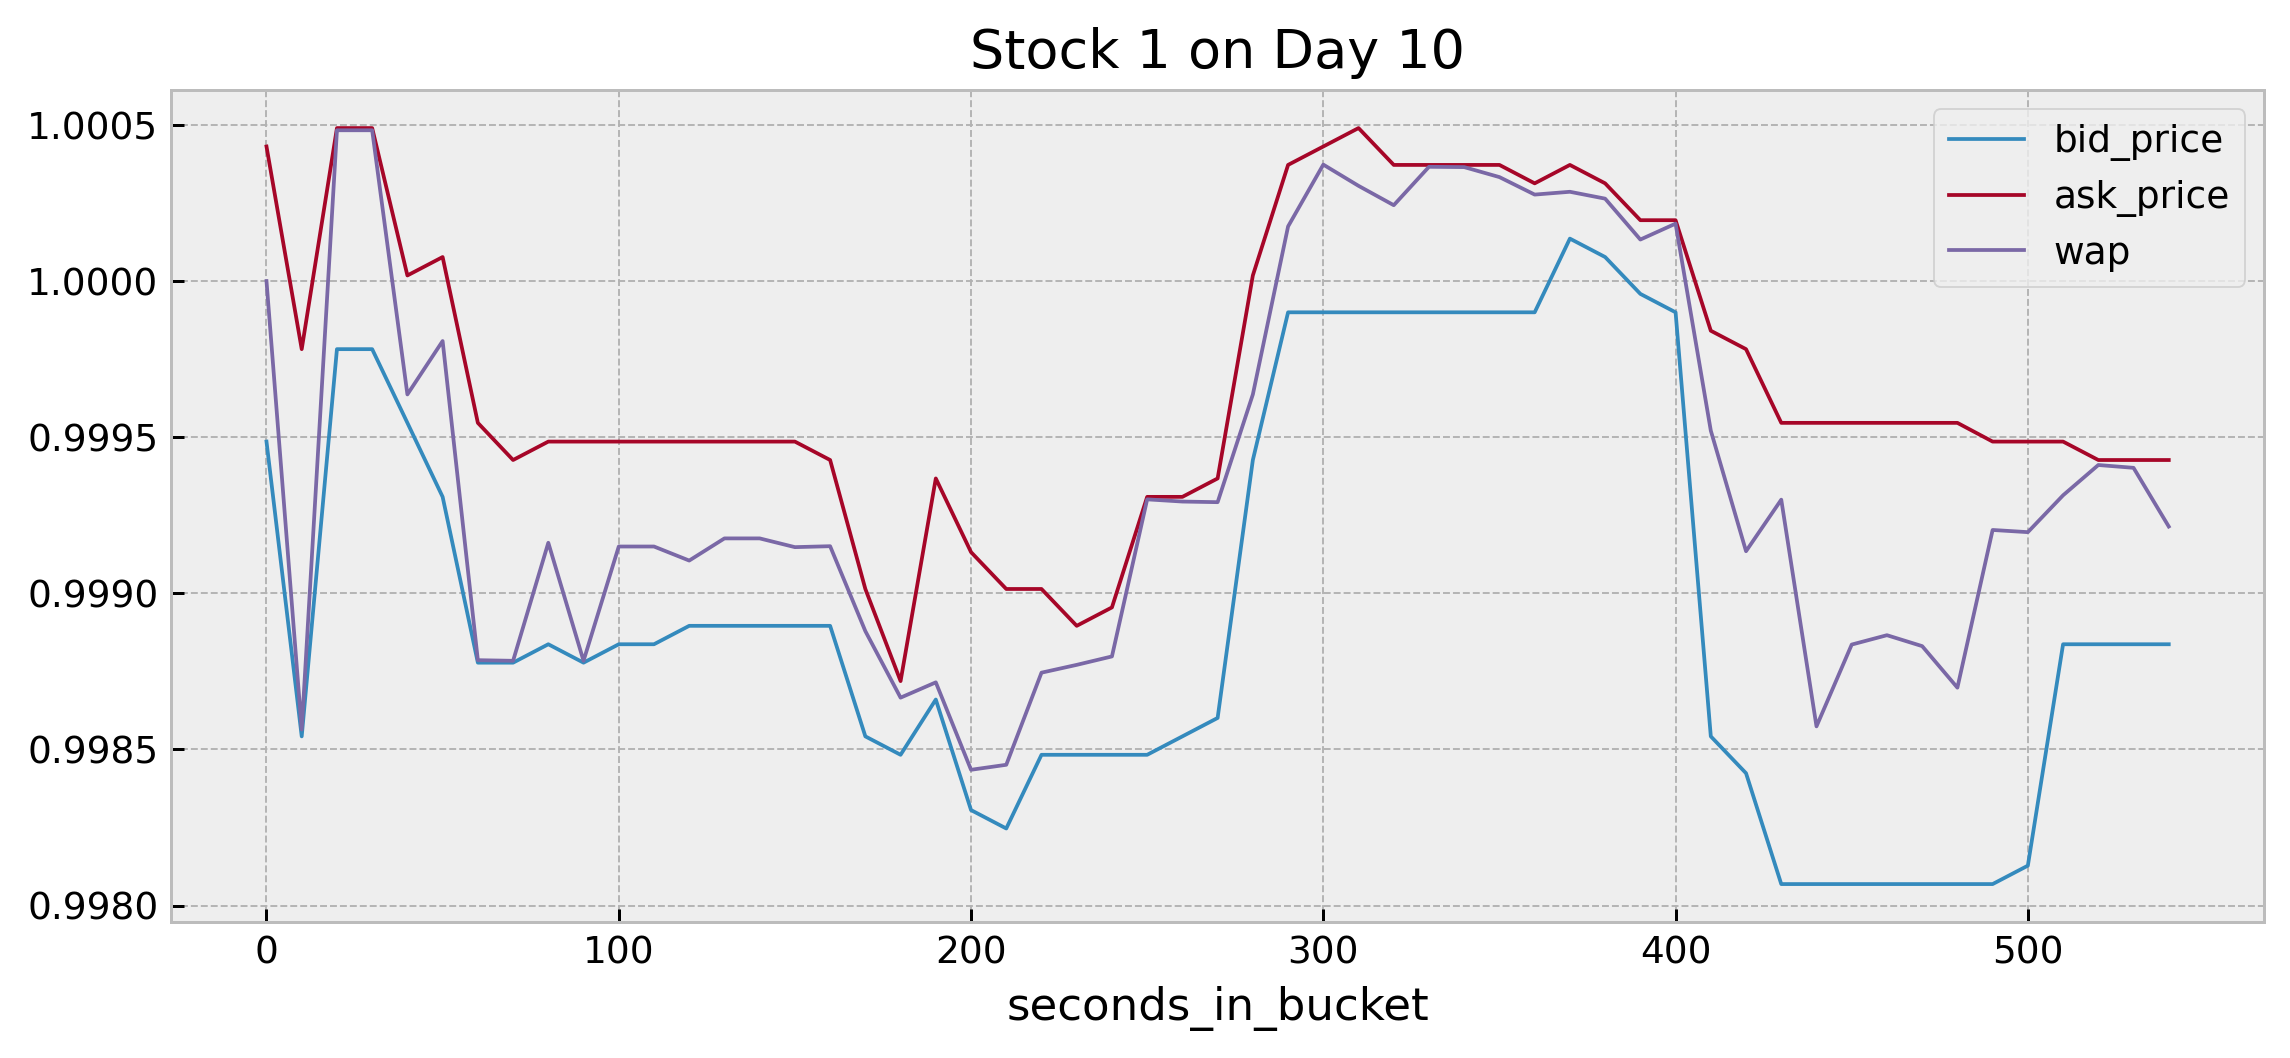

In [39]:
# We tried a few different stock_id and date_id to see the common patterns

time_series_plot(
    df=Xy_train, 
    cols=['bid_price','ask_price', 'wap'], 
    stock_id = 1,
    date_id = 10
)

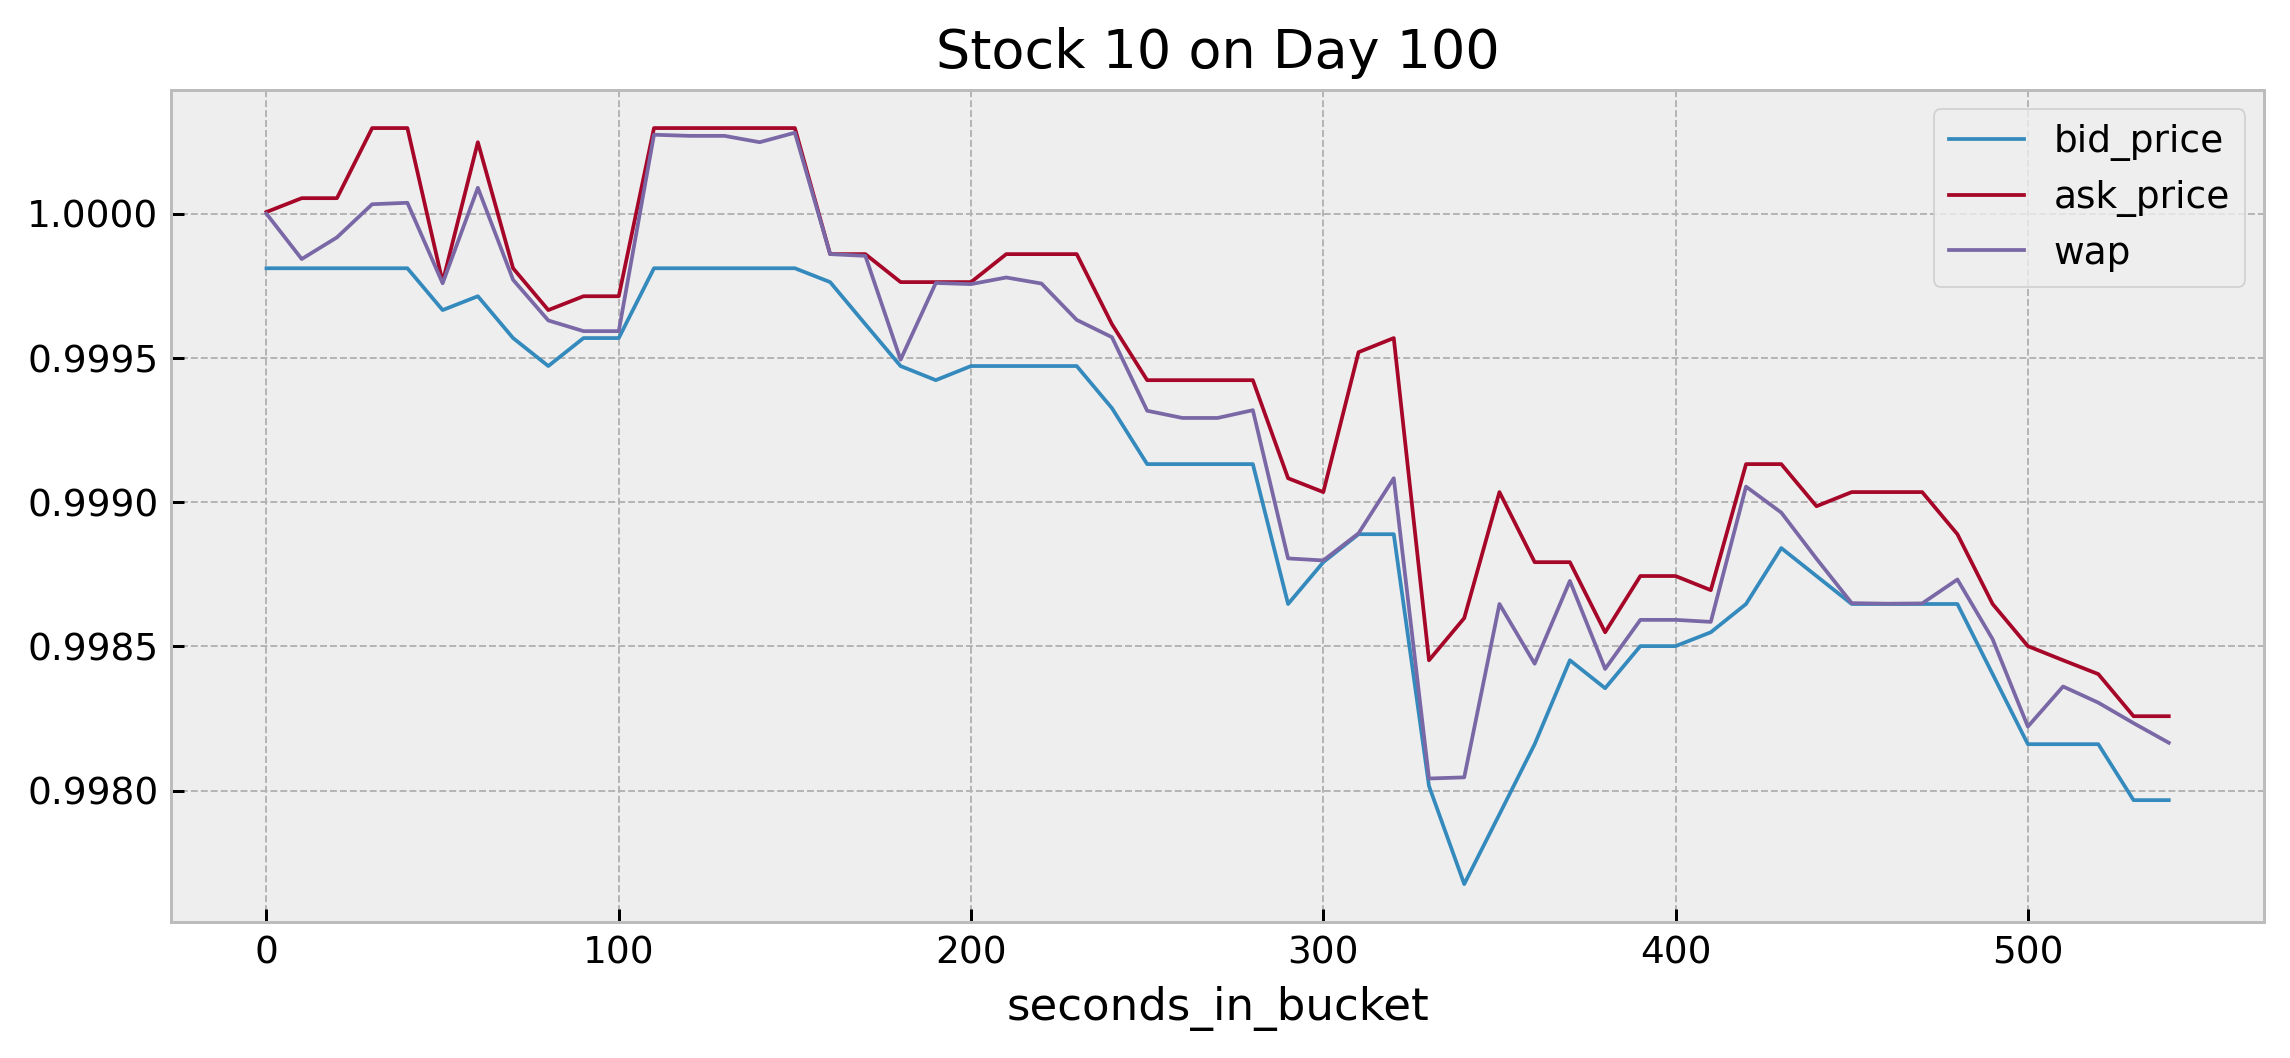

In [40]:
# Another example

time_series_plot(
    df=Xy_train, 
    cols=['bid_price','ask_price', 'wap'], 
    stock_id = 10,
    date_id = 100
)

And one more thing, all the prices shown here are converted to a price move relative to the stock `wap` (weighted average price) at the beginning of the auction period.

### 1.2.2. Auction Order Book

The concept of **Auction Order Book** is the key to understand the follwoing features:

- `imbalance_size`
- `imbalance_buy_sell_flag`
- `matched_size`
- `far_price`

So, what is an Auction Order Book? And how it differ from an (oridinary) Order Book?

**In an Auction Order Book, the orders are not immediately matched, but instead collected until the moment the auction ends.**

![](https://i.ibb.co/HFjZQV9/order-book-3.png)

In the above example, the book is referred to as **in cross**, since the best bid and ask are overlapping.

Suppose the auction ends with the book in this state, then:

- At a price of 10, 0 lots would be matched since there as no bids >= 10.

- At a price of 9, 3 lots would be matched, as there are 3 bids >=9 and 6 asks <= 9.

- At a price of 8, 4 lots would be matched, since are 7 bids>=8, and there are 4 asks<=8.

So the price which _maximizes_ the number of matched lots would be 8. In the situation like this, We would describe the Auction Order Nook in the following way:

- The **uncross price** is 8
- The **matched size** would be 4
- There are 3 Bids (7 - 4 = 3) are still unmatched, therefore, the **imbalance** would be 3 lots in the buy direction.

At any given time, the hypothetical **uncross price** (assuming the auction ends immediately) is defined as the current **far price**. 

In other words, the **far price** is the price which _maximizes_ the number of matched lots in current status of the Auction Order Book.

Nasdaq provides **far price** information 5 minutes before the closing cross (3:55 p.m.).

Describe the above situtation in terms of our "features", that would be: 

- `far_price` = 8
- `matched_size` = 4 * `reference price` (we will explain `reference price` later)
- `imbalance_size` = 3 * `reference price`
- `imbalance_buy_sell_flag` = 1 (1 for buy-side imbalance, -1 for sell-side imbalance, 0 for no imbalance)

Now let's plot some time series:

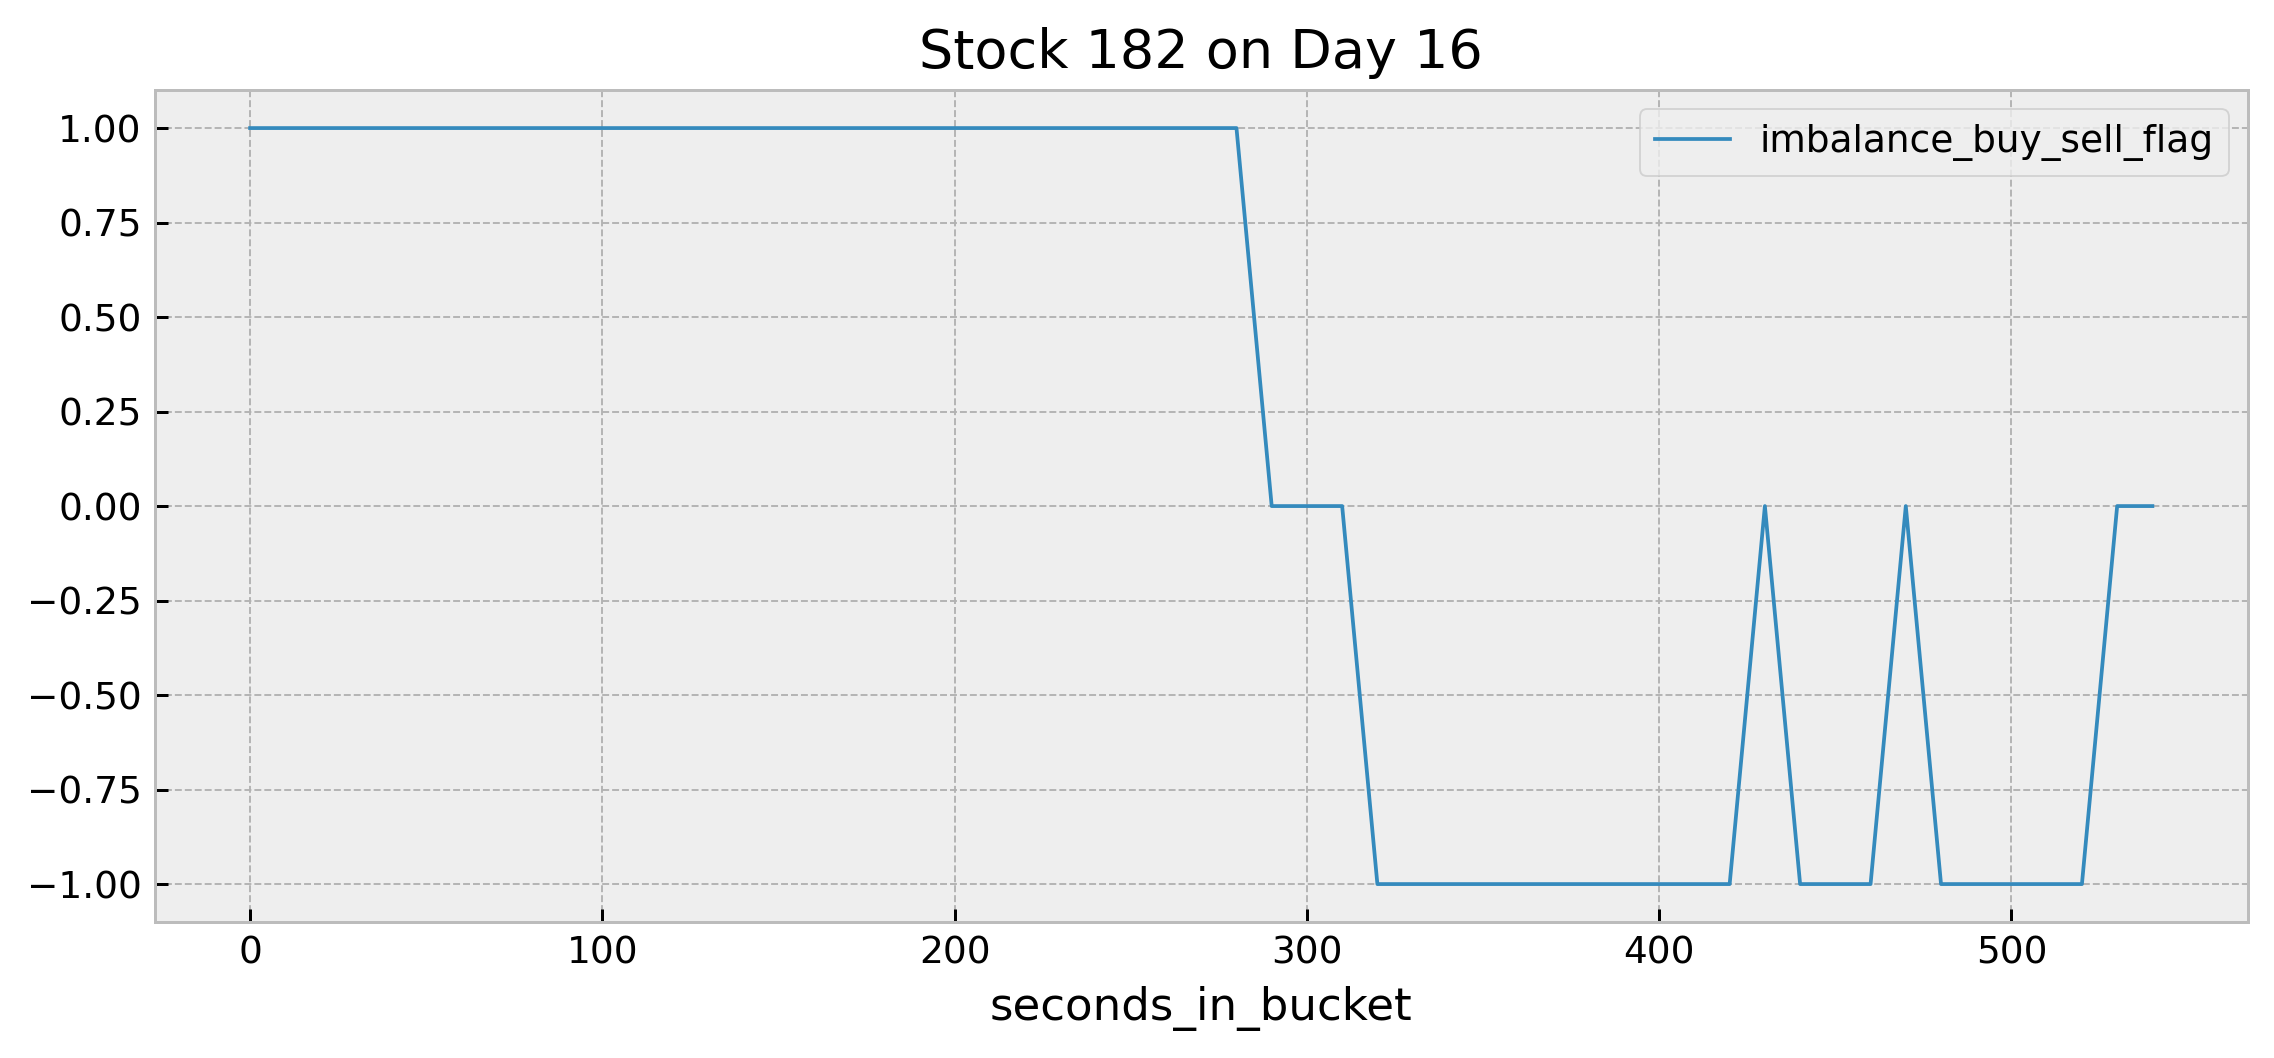

In [41]:
# To see different random stock_id and date_id, simply run the cell again
time_series_plot(
    df=Xy_train, 
    cols=['imbalance_buy_sell_flag'], 
    stock_id = np.random.randint(low=0, high=200), 
    date_id = np.random.randint(low=0, high=480),
)

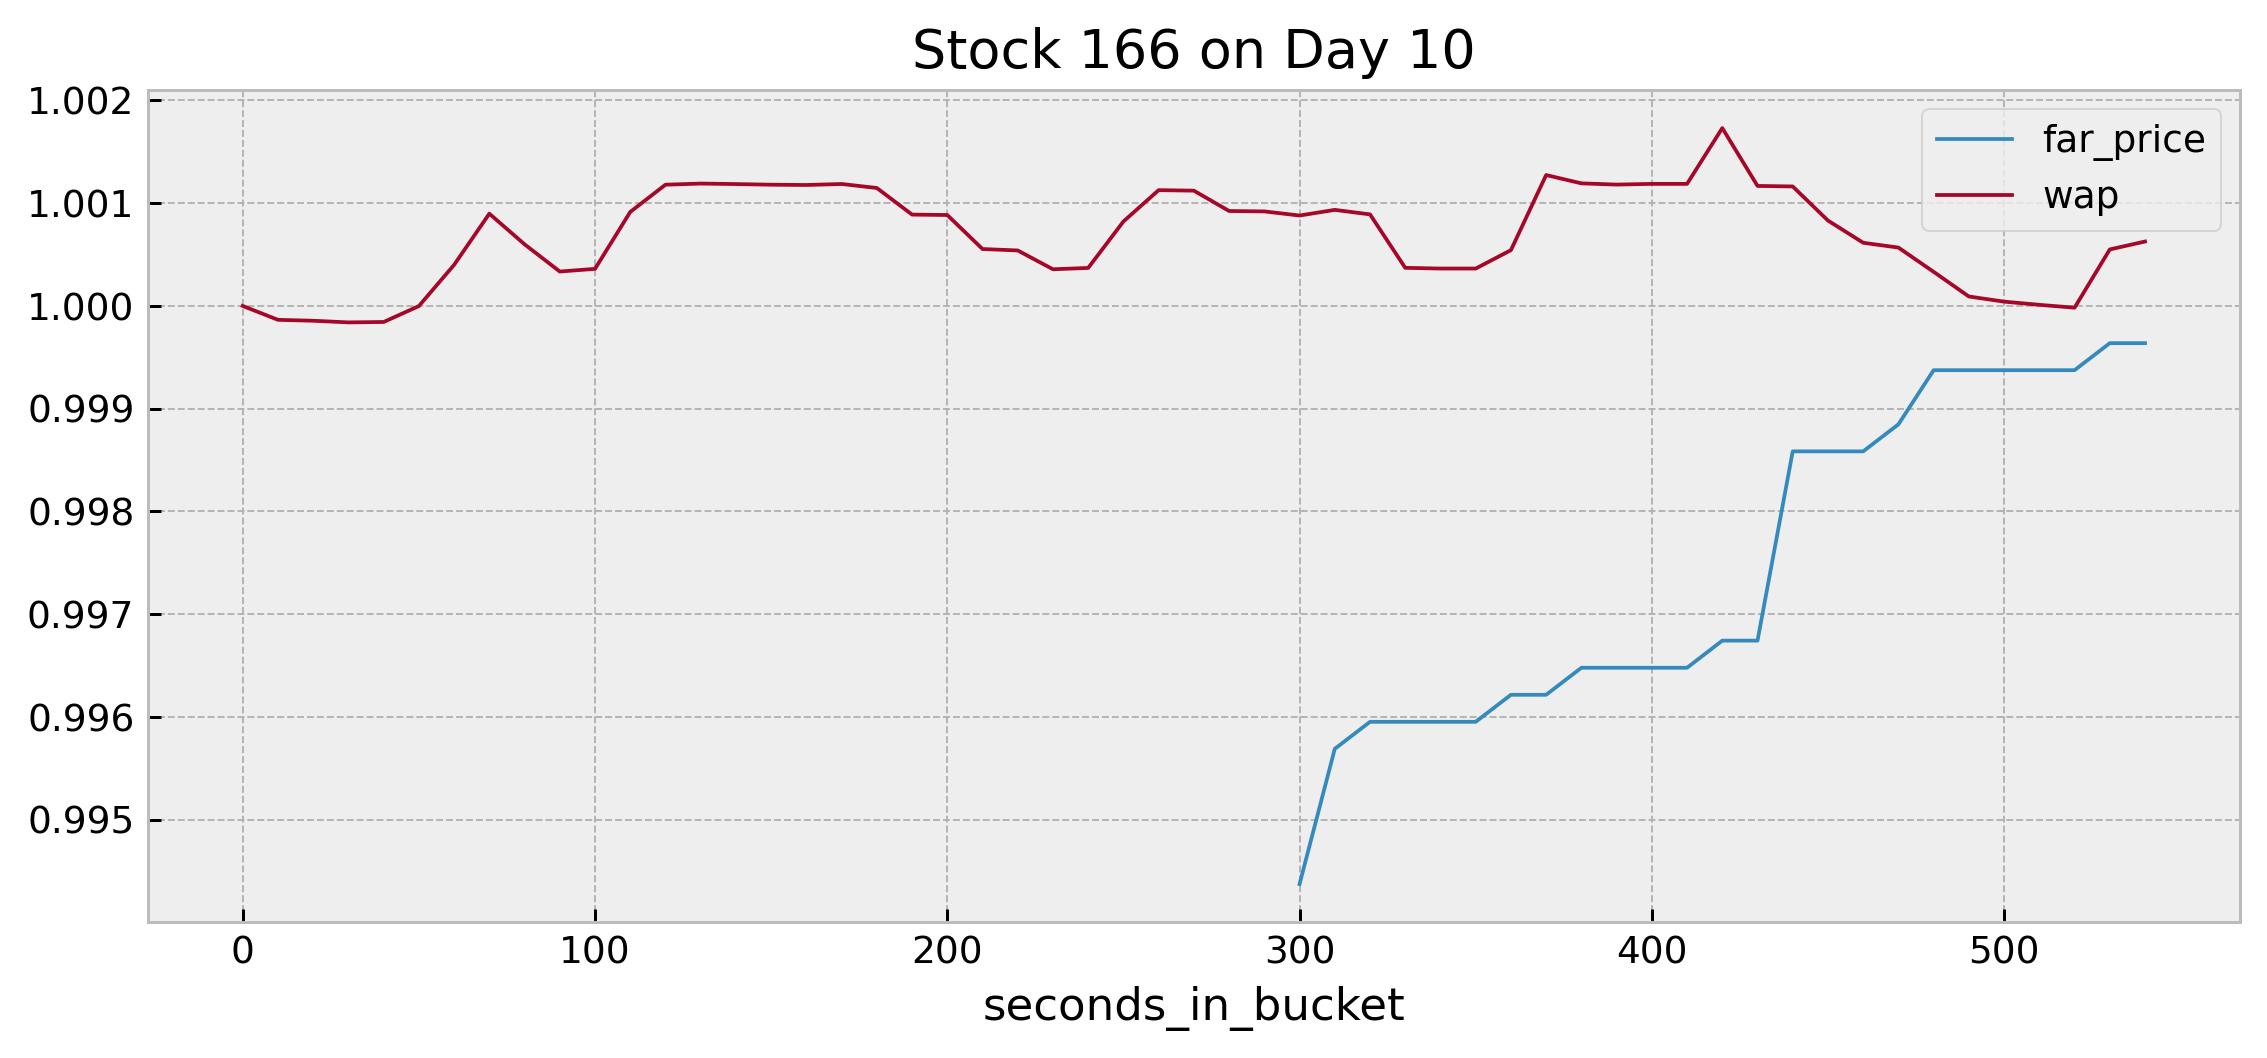

In [42]:
# Compare the far_price and wap
time_series_plot(
    df=Xy_train, 
    cols=['far_price', 'wap'],
    stock_id = np.random.randint(low=0, high=200), 
    date_id = np.random.randint(low=0, high=480),
)

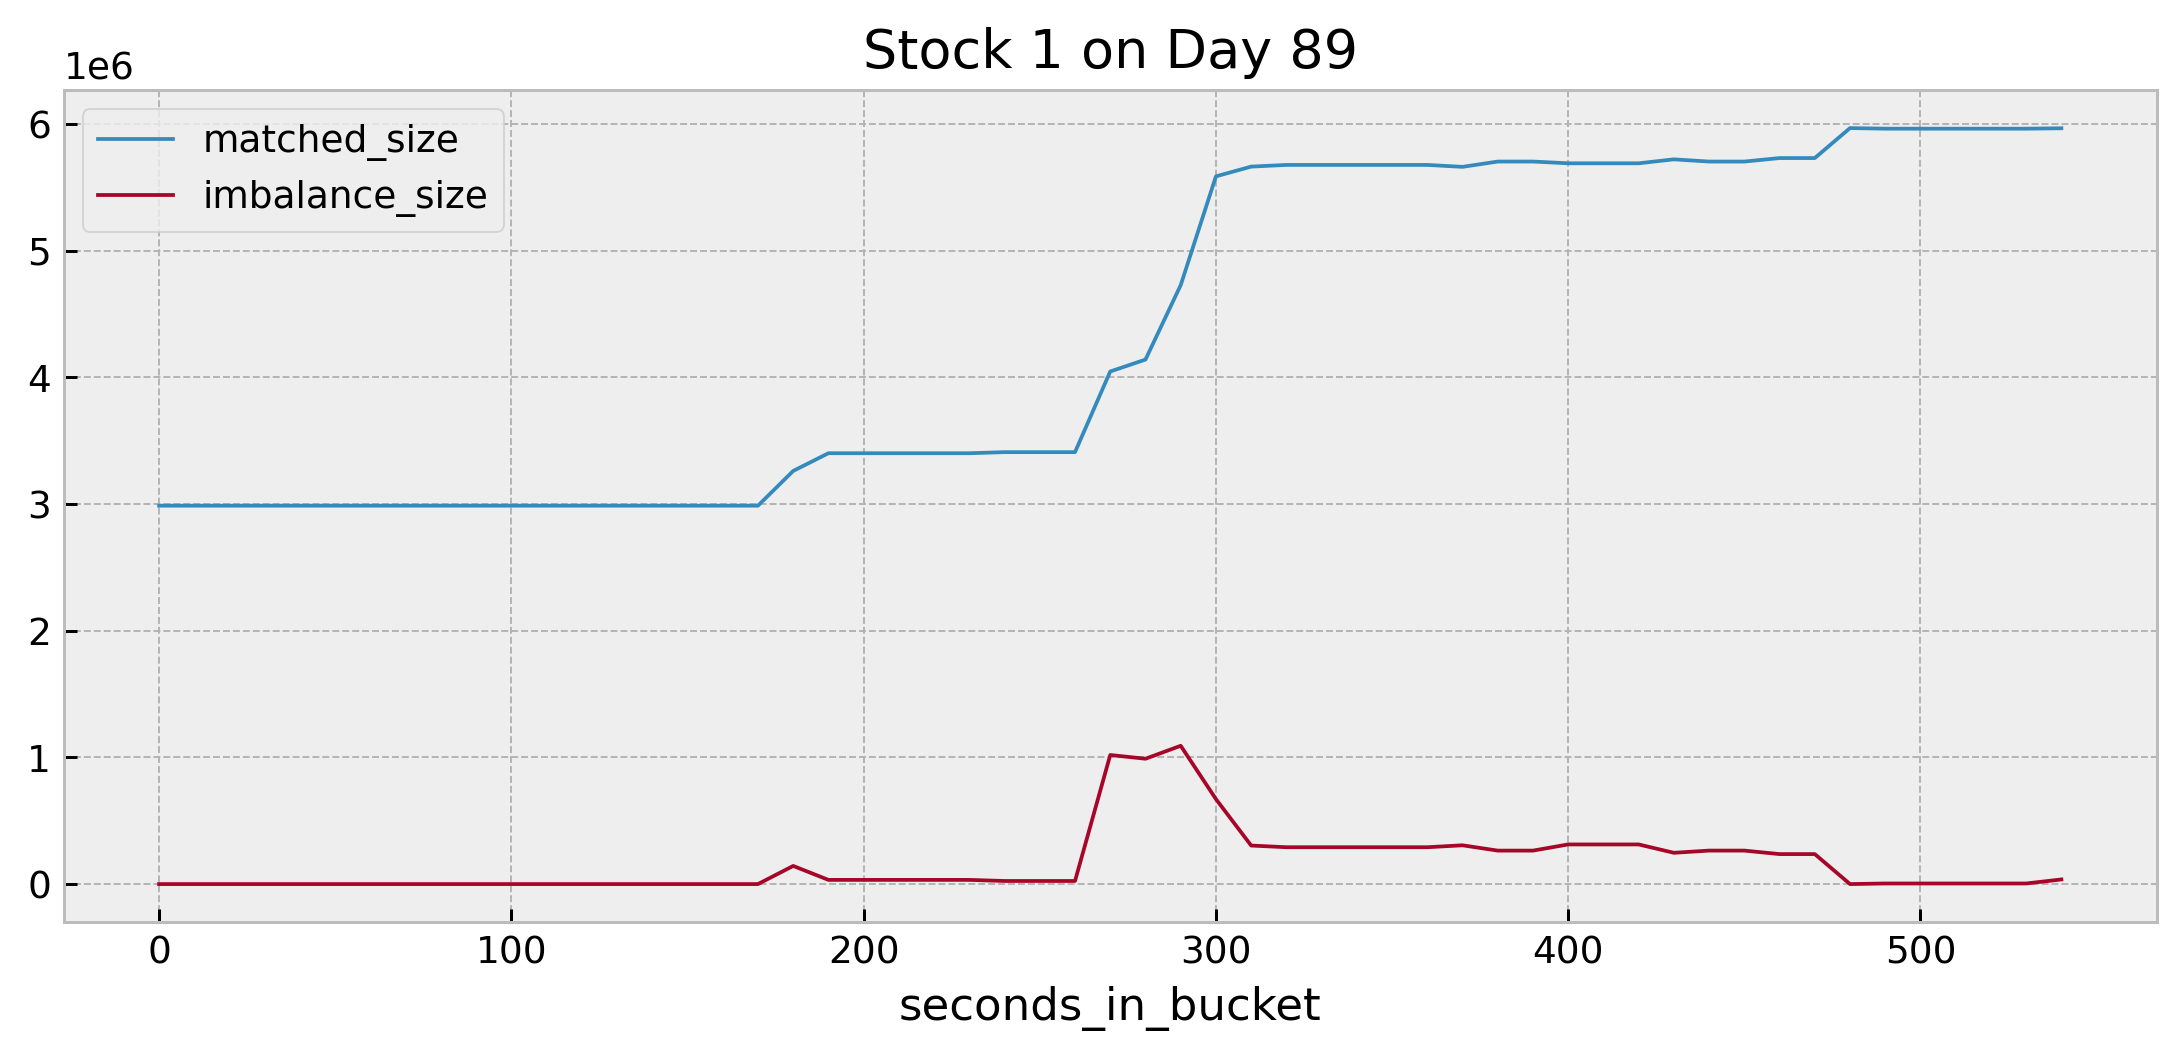

In [43]:
# Compare the matched_size and imbalance_size
time_series_plot(
    df=Xy_train, 
    cols=['matched_size', 'imbalance_size'], 
    stock_id = np.random.randint(low=0, high=200), 
    date_id = np.random.randint(low=0, high=480),
)

After plotting the time series for different stock_id and date_id for serval times, we observe a few patterns:

- `Far Price` shows data only after `second_in_bucket`=300, which corresponds to 3:55 p.m.

- `matched_size` and `imbalance_size` significantly diverge at size, after `second_in_bucket`=240 (3:54 p.m.); `imbalance_size` tends to decrease, and `matched_size` tends to increase, after this time point.

### 1.2.3. Combined Book

Finally, the rest 2 features are related to the **Combined Book**, which is the combination of **Order Book** and **Auction Order Book**.

- `reference_price`
- `near_price`

Here we combine our previous order book example & auction book example by aggregating the buying & selling interest across all price levels.

![](https://i.ibb.co/1vPFYwz/order-book-4.png)

For this combined book:

- At a price of 10, 0 lots would be matched, as there are no bids>=10.

- At a price of 9, 5 lots would be matched, as there are 5 bids>=9 and 6 asks <=9.

- At a price of 8, 4 lots would be matched, as there are 9 bids>=8 and 4 asks <=8.

So, the price which maximizes matched lots would be the price of 9. We would therefore describe the combined order book in the following way:

- The uncross price is 9
- The matched size is 5
- The imbalance would be 1 lot, in the sell direction.

The hypothetical uncross price of combined book is called the **near price**. 

Same as the **far price**, Nasdaq provides **near price** 5 minutes before the closing cross (3:55 p.m.).

Nasdaq also provides an indication of the fair price called the **reference price**. The reference price is calculated as follows:

- If the near price is between the best bid and ask, then the reference price is equal to the near price

- If the near price > best ask, then reference price = best ask

- If the near price < best bid, then reference price = best bid So the reference price is the near price bounded between the best bid and ask.

Now let's put the `bid_price`, `ask_price`, `wap`, `far_price`, `near_price`, and `reference_price` together:

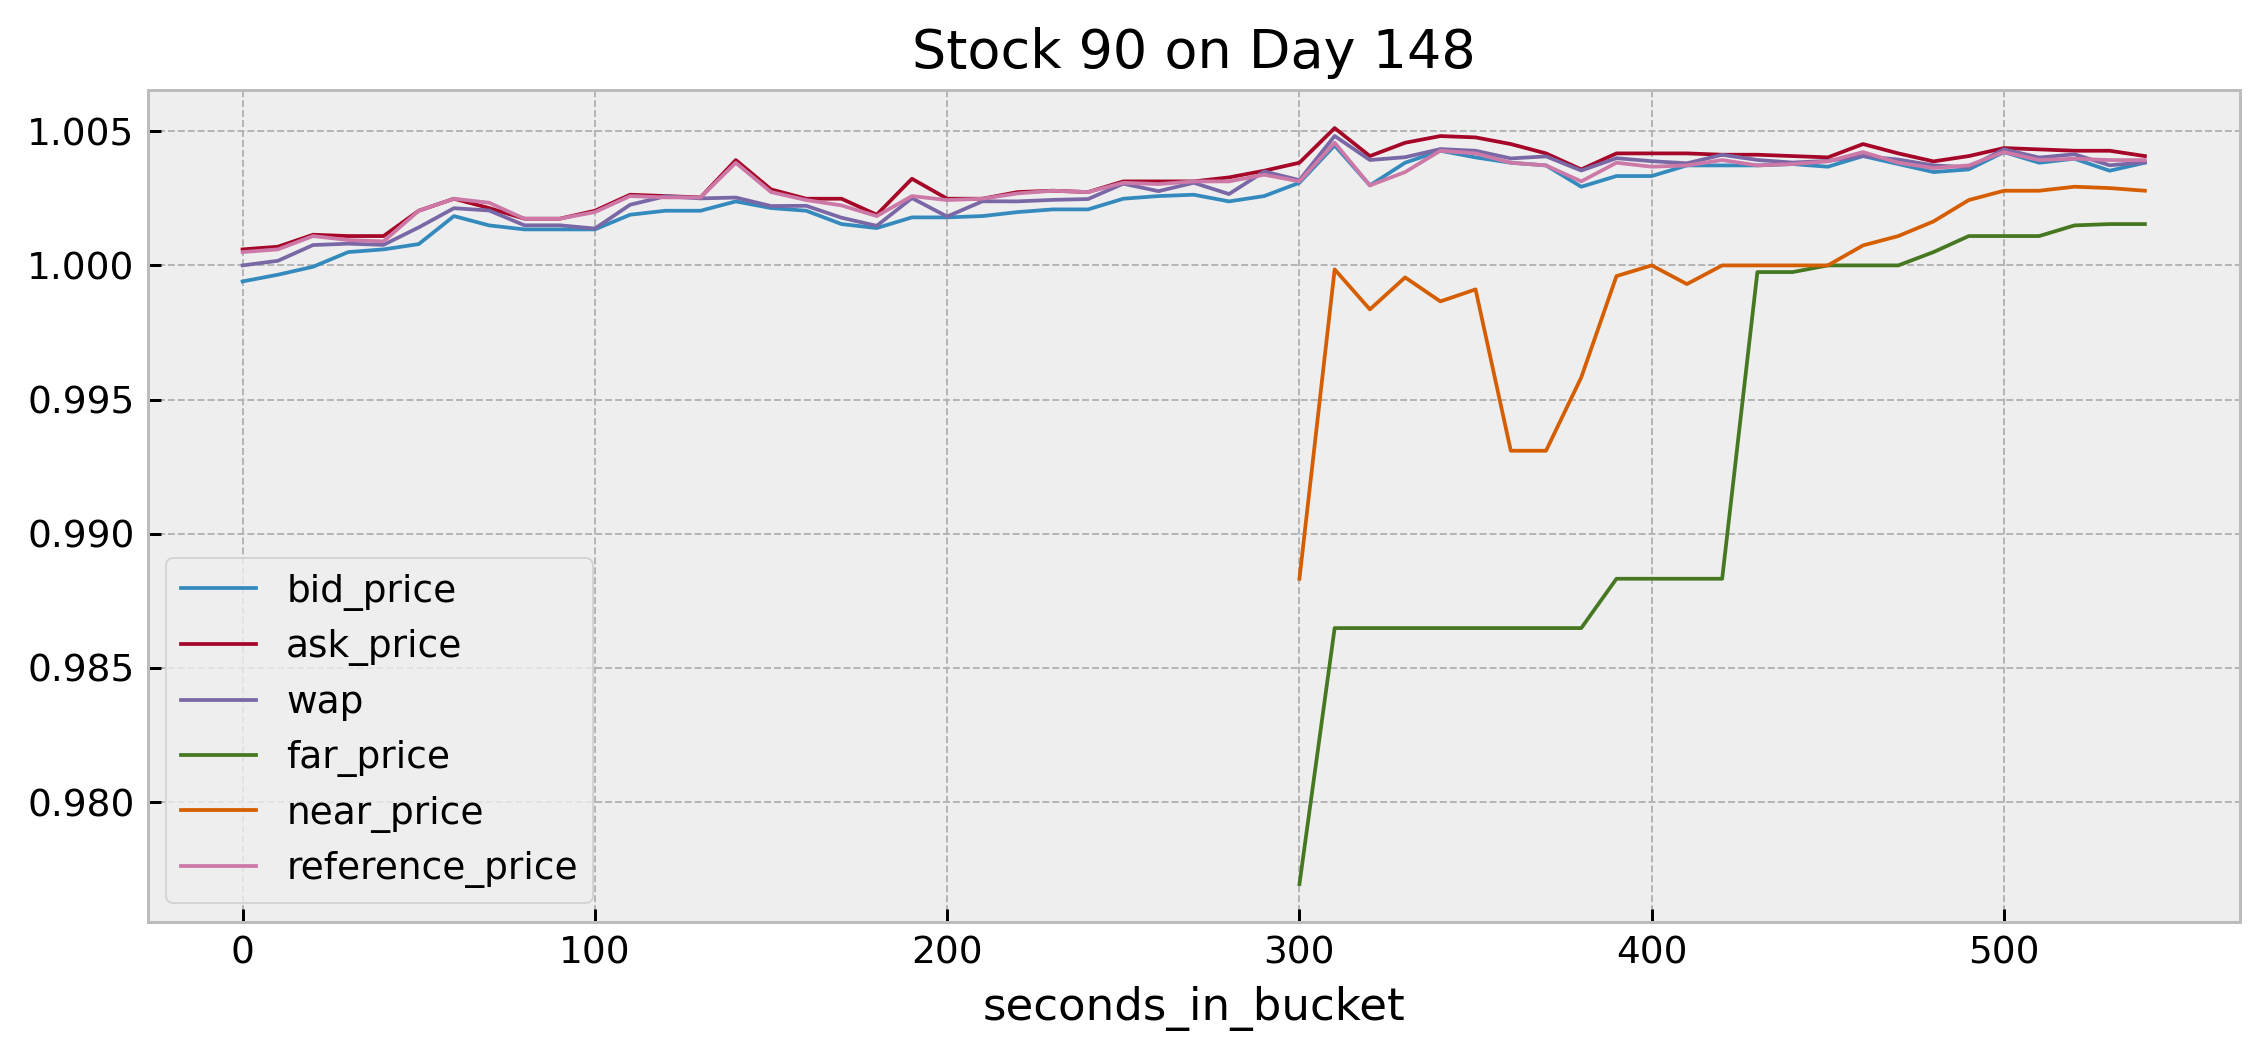

In [44]:
time_series_plot(
    df=Xy_train, 
    cols=['bid_price', 'ask_price', 'wap', 'far_price', 'near_price', 'reference_price'], 
    stock_id = np.random.randint(low=0, high=200), 
    date_id = np.random.randint(low=0, high=480),
)

Finally, according to the [Dataset Description](https://www.kaggle.com/competitions/optiver-trading-at-the-close/data), all price related columns are converted to a price move relative to the stock `wap` at the beginning of the auction period. 

In other words, the `wap` should be 1 for all beginnings of our Time Series. Let's verify this programatically.

In [45]:
# Find all wap not equal 1 when seconds_in_bucket == 0
Xy_train.query("seconds_in_bucket == 0").query('wap != 1')

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
369508,131,35,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1925,35_0_131
3555081,101,328,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,18040,328_0_101
4215138,158,388,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,21340,388_0_158
4764999,19,438,0,NaN,-1,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,24090,438_0_19


Only 4 time series do not have `wap` equal to 1 at the beginning. 

And after we examine them one by one, we found that their `wap` are all NA.

In [46]:
# Let's verify the above statement programmatically

ts1 = Xy_train.query("stock_id == 131 & date_id == 35")["wap"]
ts2 = Xy_train.query("stock_id == 101 & date_id == 328")["wap"]
ts3 = Xy_train.query("stock_id == 158 & date_id == 388")["wap"]
ts4 = Xy_train.query("stock_id == 19 & date_id == 438")["wap"]

pd.concat([ts1, ts2, ts3, ts4], axis=0).isna().all()

True

## 1.3 Understand the target (WIP 👷)

> According to the [Dataset Description](https://www.kaggle.com/competitions/optiver-trading-at-the-close/data), `target` is the 60 second future move in the `wap` of the stock, less the 60 second future move of the synthetic index.

# 2. LightGBM Baseline

In [47]:
# We split the data here, and use them in the following sections

X_train = Xy_train.query("target.notna()").drop(['row_id', "time_id"], axis=1)
y_train = X_train.pop("target")

## 2.1. Naive Baseline

The following code submit a prediction that all target = 0. 

To understand how the submission API work, jump to the final section of this notebook.

In [26]:
# env = optiver2023.make_env()
# iter_test = env.iter_test()

# counter = 0
# for (test, revealed_targets, sample_prediction) in iter_test:
#     sample_prediction['target'] = 0
#     env.predict(sample_prediction)
#     counter += 1

The Naive Forecast submission yields a **score of 5.465** (2023-09-25).

As of 2023-09-25, the 1st best score on the Leaderboard is 5.3441 and the 10th best score is 5.3706.

Could the small gap between the score of our Naive Forecast and the Best score on the Leaderboard suggest that the data are of low predictability?

## 2.2. Simplest LightGBM Solution

Here, we aim to provide a valid LightGBM solution using as few lines of code as possible. To see if it beats the Naive baseline.

In [27]:
# env = optiver2023.make_env()
# iter_test = env.iter_test()

# model = lightgbm.LGBMRegressor(
#     random_state = SEED, 
#     objective = 'mae', 
#     device_type = 'gpu'
# )

# model.fit(X_train, y_train)

# counter = 0
# for (test, revealed_targets, sample_prediction) in iter_test:
#     sample_prediction['target'] = model.predict(test.drop('row_id', axis = 1))
#     env.predict(sample_prediction)
#     counter += 1

The LightGBM Baseline submission yields a **score of 5.4209** (2023-09-25).

- 5.465 - 5.4209 = 0.0441 (Baseline LightGBM imporved the score from Naive by 0.0441)

- 5.465 - 5.3706 = 0.0944 (10th best score on the Leaderboard imporved the score by 0.0944)

- 5.465 - 5.3441 = 0.1209 (1st best score on the Leaderboard imporved the score by 0.1209)

Still a long way to go...

## 2.3. Improved LightGBM Solution

In [28]:
# def calculate_imbalance_features(df):
#     # Calculate and add imbalance feature 1 (imb_s1)
#     df['imb_s1'] = df.eval('(bid_size - ask_size) / (bid_size + ask_size)')  

#     # Calculate and add imbalance feature 2 (imb_s2)
#     df['imb_s2'] = df.eval('(imbalance_size - matched_size) / (matched_size + imbalance_size)') 

#     return df

In [29]:
# estimator = lightgbm.LGBMRegressor(
#     boosting_type='gbdt', 
#     num_leaves=31, 
#     max_depth=-1, 
#     learning_rate=0.1, 
#     n_estimators=100, 
#     subsample_for_bin=200000, 
#     objective='mae', 
#     class_weight=None, 
#     min_split_gain=0.0, 
#     min_child_weight=0.001, 
#     min_child_samples=20, 
#     subsample=1.0, 
#     subsample_freq=0, 
#     colsample_bytree=1.0, 
#     reg_alpha=0.0, 
#     reg_lambda=0.0, 
#     random_state=SEED, 
#     n_jobs=-1, 
#     importance_type='split',
#     force_row_wise=True
# )

# val_predictions = np.zeros(len(X_train))
# val_scores = []

# splitter = sk.model_selection.TimeSeriesSplit(5).split(X_train, y_train)

# for fold, (train_idx, val_idx) in enumerate(splitter):
#     model = sk.base.clone(estimator)

#     # Define train and val set
#     X_train = X_train.iloc[train_idx]
#     y_train = y_train.iloc[train_idx]
#     X_val = X_train.iloc[val_idx]
#     y_val = y_train.iloc[val_idx]

#     model.fit(X_train, y_train)
#     val_scores.append(sk.metrics.mean_absolute_error(model.predict(X_val), y_val))

# print(f'Val Score: {np.mean(val_scores):.2f} ± {np.std(val_scores):.5f}')

In [30]:
# import optiver2023

# env = optiver2023.make_env()
# iter_test = env.iter_test()

# model.fit(X_train, y_train)

# counter = 0
# for (test, revealed_targets, sample_prediction) in iter_test:
#     sample_prediction['target'] = model.predict(test.drop('row_id', axis = 1))
#     env.predict(sample_prediction)
#     counter += 1

# 3. Final Thoughts

In [31]:
END = pd.Timestamp.now()
time_elapsed = (END - START).total_seconds()
print(f"Notebook Total Time: {time_elapsed:.2f}s")

Notebook Total Time: 35.09s
